In [1]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler 
import model 

import numpy as np
from simtk import openmm, unit

from pydiffmap import diffusion_map as dmpy
import helpers
import model

In [2]:
# qid = np.load('../Data_Tests/Alanine/stein.npy')
# print(qid)

In [3]:
diffmapmethod='T300/DiffMap/'
methodName='frontier_points_corner_change_temperature_off'
methodNameFolder=diffmapmethod+methodName

#######################
# target temperature
T=300.0


metric_choice = 'euclidean'
  
dataName='Results/'
folderName='/Users/zofia/github/DFM/'
modelName='Alanine'

dataFolderName = folderName+dataName+modelName+'/'+methodNameFolder

# results from this code will be saved here:
simulationFolder=dataFolderName+'/Figures'

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

print(dataFolderName)

mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())

temperature =  T * unit.kelvin#300 * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 1.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')



/Users/zofia/github/DFM/Results/Alanine/T300/DiffMap/frontier_points_corner_change_temperature_off
Maximal position value in one direction is 0.86477354000000006
PBC box size set to 8.6477354000000002
nanometer
System has 22 particle(s)
545.500802393 K


In [5]:

data_folder_enhanced = 'LangevinUnbiasFigures/Alanine/'
newpath = os.path.join(os.getcwd(),data_folder_enhanced)
if not os.path.exists(newpath):
        os.makedirs(newpath)


[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4
  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9
 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14
 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19]


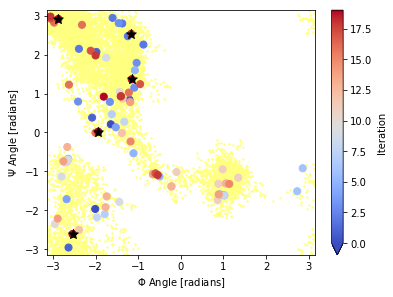

In [6]:
modnr=1
def plotSamplingDihedrals(nameData, nameFrontier, samplerAlgo, numberOfFrontierPoints, methodName,singleDataFrame=False, X_FT=None):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if X_FT is None:
        X_FT = helpers.loadData(nameData, top, modnr)
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=[1,1,0.5]);
            
    X_frontier = helpers.loadData(nameFrontier, top, modnr)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
         
    nrIt = int(len(anglesFrontierPoints) / numberOfFrontierPoints)
    colfp = np.asarray(range(0,nrIt))
    cfp=list()
    for i in range(numberOfFrontierPoints):
        cfp.append(colfp)
    cfarr=(np.asarray(cfp).transpose())
    cfarr=cfarr.reshape(len(anglesFrontierPoints))
    print(cfarr)
    
    axfp = ax.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], s=50, c = cfarr, cmap ='coolwarm',vmin=0, vmax=cfarr.max());
    cbar = plt.colorbar(axfp,extend='min')
    cbar.set_label('Iteration')
    ax.scatter(anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 0], anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 1], s=100, c = 'k', marker = '*')
    
    #ax.set_title('Alanine dipeptide ')
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    
    #plt.savefig(dataFolderName+'/corner_points.pdf',  format='pdf', dpi=1, bbox_inches='tight')
    #plt.savefig(dataFolderName+'/corner_points.png',  format='png', dpi=None, bbox_inches='tight')
    plt.savefig(data_folder_enhanced+'/enhanced_corner.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
if methodName == 'local_frontier_points':
    numberOfFrontierPoints=1 #
else:
    numberOfFrontierPoints=5
plotSamplingDihedrals(dataFolderName+'/Traj/*.h5', dataFolderName+'/Traj/FrontierPoints/'+'*.h5',  smpl, numberOfFrontierPoints, methodName)

In [7]:
def compute_dihedrals_phi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,0]

def compute_dihedrals_psi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,1]

colective_variable = compute_dihedrals_phi
cv_name = 'Dihedral angle phi'




# Load trajectory here

Loaded trajectory of length 10000


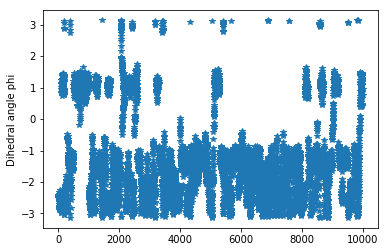

In [8]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = False

modnr=1
X_FT = helpers.loadData(dataFolderName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r, '*')
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [10]:
def plotSamplingDihedrals_fromData(X_FT, topology, methodName=None, color=None, title=None, leader_set=None):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=topology #md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    if color is None:
        clr =[1,1,0.5]
    else:
        clr = color
        
    if leader_set is None:
        pass
    else:
        clr = np.zeros(angles.shape[0])
        clr[leader_set] += 0.1 
        
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=clr);
    ax.set_title(title)
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    if title is not None:
        plt.savefig('bla'+'.png',  format='png', dpi=100, bbox_inches='tight')
    plt.show()



In [11]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

trj = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb', X_FT) 
print(trj.trajectory)
ref = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb')#, X_FT[0,:,:]) 
alignment = align.AlignTraj(trj, trj)
alignment.run()
X_aligned = np.zeros(X_FT.shape)
ci=0
for ts in trj.trajectory:
    X_aligned[ci] = trj.trajectory.ts.positions
    ci=ci+1

print(X_aligned.shape)
print(alignment)
X_FT=X_aligned

/Users/zofia/miniconda3/lib/python3.6/site-packages/MDAnalysis/__init__.py:245: UserWarning: #####
MDAnalysis on python 3 is highly experimental!
It is mostly non functional and dramatically untested.
Use at your own risks!!!

  ''')


<MemoryReader with 10000 frames of 22 atoms>
(10000, 22, 3)


In [126]:



def compute_free_energy(cv, weights=None, nrbins=100, err_bar = False):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)
    
    
    if err_bar == True:
        
        dat, bin_edges = pi_marginal, bin_edges#np.histogram(cv, bins = nrbins, weights = weights)
        yerrs = np.sqrt(dat)

        nevents = float(sum(dat))
        binwidth = (bin_edges[1]-bin_edges[0])
        dat = dat/nevents/binwidth
        yerrs = yerrs/nevents/binwidth
        
        #yerrs = -np.log(yerrs)

       
        xerrs = bin_centers
        
        return free_energy, bin_centers, xerrs, yerrs 
    else:

        return free_energy, bin_centers
   

#  Stein force

In [13]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    force = []
    
    for n in range(len(leader_set)):
        force.append( smpl.model.force(XL[leader_set[n]]))

    return force

def compute_force_all(XL):
       
    force = []
    
    for n in range(len(XL)):
        force.append( smpl.model.force(XL[n]))

    return force

def compute_stein_force(XL, leader_set, model):
   
    force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    forcenp = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(leader_set)):
        forcenp.append(force[n].value_in_unit(smpl.model.force_unit))
    
    forcenp = np.asarray(forcenp)
    # create numpy array from the list XL which has also units
    
    XreshList = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(XL)):
        XreshList.append(XL[n].value_in_unit(model.x_unit))
    
    Xresh = np.asarray(XreshList)
    # reshape for neighbor search steps x DOF
    Xresh = Xresh.reshape(Xresh.shape[0],Xresh.shape[1]*Xresh.shape[2])
    # choose leader particles using the index set leader_set
    X_leader = np.copy(Xresh[leader_set,:])
    
    force_resh = forcenp.reshape(forcenp.shape[0],forcenp.shape[1]*forcenp.shape[2])
   
    # kernel scaling parameter
    h=0.04
    
    distances = cdist(X_leader, Xresh)
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel.transpose(), force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_MDforce = f_MDforce.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add force unit and divide by kT
    f_MDforce = f_MDforce * model.force_unit / smpl.kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
    f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(Xresh.shape[1])) * Xresh
    f_der = f_der / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_der = f_der.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add unit
    f_der = f_der * model.x_unit**(-1)
    
    return f_MDforce + f_der


def compute_stein_force_split(XL, leader_set, model):
   
    force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    forcenp = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(leader_set)):
        forcenp.append(force[n].value_in_unit(smpl.model.force_unit))
    
    forcenp = np.asarray(forcenp)
    # create numpy array from the list XL which has also units
    
    XreshList = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(XL)):
        XreshList.append(XL[n].value_in_unit(model.x_unit))
    
    Xresh = np.asarray(XreshList)
    # reshape for neighbor search steps x DOF
    Xresh = Xresh.reshape(Xresh.shape[0],Xresh.shape[1]*Xresh.shape[2])
    # choose leader particles using the index set leader_set
    X_leader = np.copy(Xresh[leader_set,:])
    
    force_resh = forcenp.reshape(forcenp.shape[0],forcenp.shape[1]*forcenp.shape[2])
   
    # kernel scaling parameter
    h=0.1
    
    distances = cdist(X_leader, Xresh)
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel.transpose(), force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_MDforce = f_MDforce.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add force unit and divide by kT
    f_MDforce = f_MDforce * model.force_unit / smpl.kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
    f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(Xresh.shape[1])) * Xresh
    f_der = f_der / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_der = f_der.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add unit
    f_der = f_der * model.x_unit**(-1)
    
    return f_MDforce + f_der





In [14]:
def align_with_mdanalysis(X_FT, smpl):

    trj = mda.Universe(smpl.model.modelName+'.pdb', X_FT)
    ref = mda.Universe(smpl.model.modelName+'.pdb')
    # trj = mda.Universe('/Users/zofia/github/DFM/alanine.xyz', X_FT)
    # print(trj.trajectory)
    # ref = mda.Universe('/Users/zofia/github/DFM/alanine.xyz')#, X_FT[0,:,:])


    alignment = align.AlignTraj(trj, ref)#, filename='rmsfit.dcd')
    alignment.run()
    X_aligned = np.zeros(X_FT.shape)
    ci=0
    for ts in trj.trajectory:
        X_aligned[ci] = trj.trajectory.ts.positions
        ci=ci+1

    #X_aligned = (trj.trajectory.positions)
    #print(X_aligned.shape)
    #print(alignment)
    return X_aligned

def rmsd_align(XL):
    
    xx=[]
    for i in range(len(XL)):
        xx.append(XL[i].value_in_unit(smpl.model.x_unit))
        
    xx=np.asarray(xx)
    #print(xx.shape)
    
    xx = align_with_mdanalysis(xx, smpl)
    
    XL=[]
    for i in range(xx.shape[0]):
        XL.append(unit.Quantity(xx[i], smpl.model.x_unit))
    return XL
    
#XL = rmsd_align(XL)

# Compute first DCs to chose initial conditions

Get the target density at sampled data points
... might take a while ...
Done


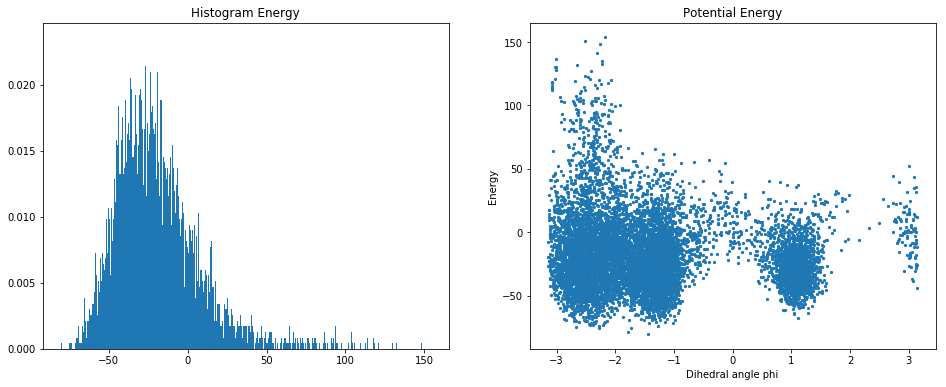

In [15]:
print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
#qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

#fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [16]:
import pydiffmap as mdpy

################ diffusion diffmaps

epsilon='bgh'
nrNeighbors=5000

compute_spectral_decomposition = 1

if nrNeighbors>=X_FT.shape[0]:
        nrNeighbors=int(0.9*X_FT.shape[0])

Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

    
if compute_spectral_decomposition==0:
        my_kernel = dmpy.kernel.Kernel(kernel_type='gaussian', k=nrNeighbors,
                                  epsilon=epsilon,
                                  metric='euclidean')
        my_kernel.fit(Xresh)
        
        K=my_kernel.compute(Xresh)
        q = np.array(K.sum(axis=1)).ravel()
else:
    mydmap = dmpy.DiffusionMap(alpha = 1, n_evecs = 8, epsilon = epsilon,  k=nrNeighbors, metric='euclidean')#, neighbor_params = {'n_jobs':-4})    
    dmap = mydmap.fit_transform(Xresh, weights = qTargetDistribution)
     
    P = mydmap.P
    evals = mydmap.evals
    evecs = mydmap.evecs

    [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
    phi = np.real(evecsT.ravel())

    q = mydmap.q

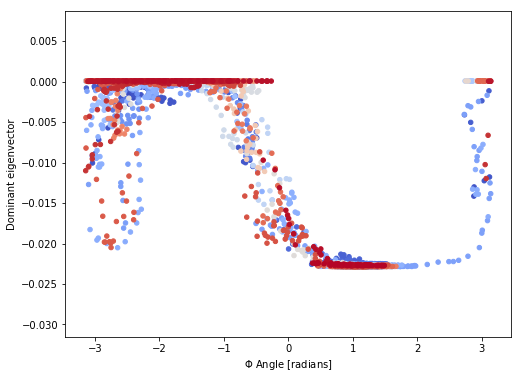

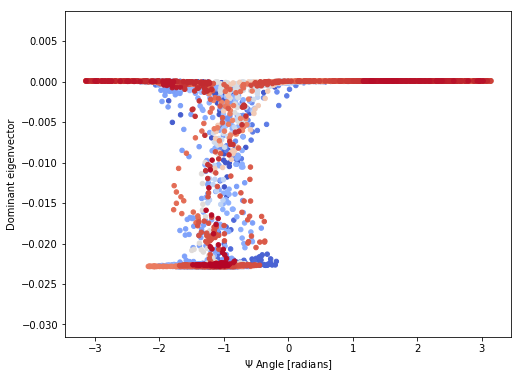

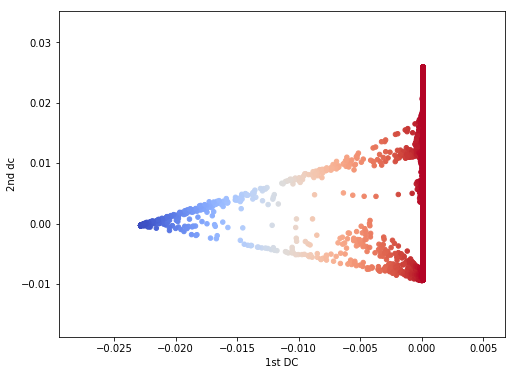

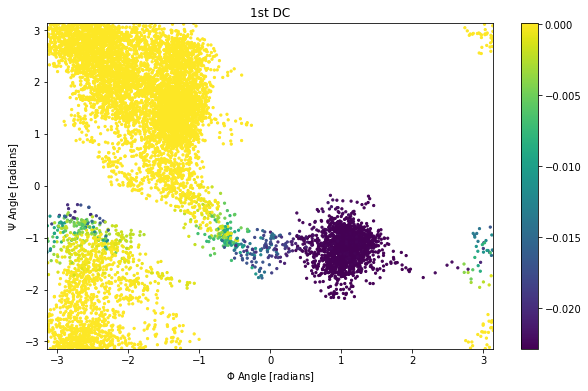

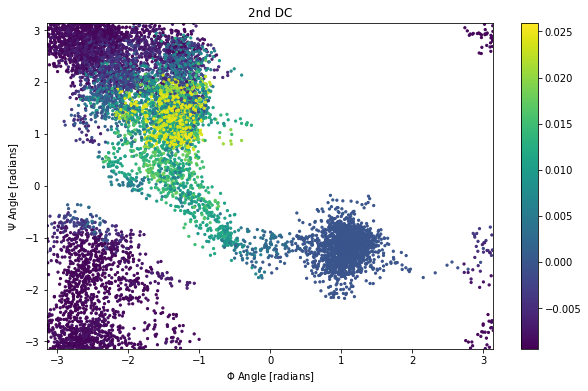

In [21]:
import matplotlib.cm as cm



if compute_spectral_decomposition==1:
    #cv=compute_dihedrals_psi(X_FT)
    cv=compute_dihedrals_phi(X_FT)

    fig = plt.figure(figsize=(8,6))
    plt.scatter(cv, evecs[:,0], s=20, c=range(len(X_FT)), cmap = cm.coolwarm)
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.ylabel('Dominant eigenvector')
    
    plt.savefig(data_folder_enhanced+'/dc1_phi.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
    
    
    cv=compute_dihedrals_psi(X_FT)
    #cv=compute_dihedrals_phi(X_FT)

    fig = plt.figure(figsize=(8,6))
    plt.scatter(cv, evecs[:,0], s=20,c=range(len(X_FT)),  cmap = cm.coolwarm)
    plt.xlabel(r'$\Psi$ Angle [radians]')
    plt.ylabel('Dominant eigenvector')
    plt.savefig(data_folder_enhanced+'/dc1_psi.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    

    fig = plt.figure(figsize=(8,6))
    plt.scatter(evecs[:,0], evecs[:,1], s=20, c=evecs[:,0], cmap = cm.coolwarm)
    plt.xlabel('1st DC')
    plt.ylabel('2nd dc')
    plt.savefig(data_folder_enhanced+'/dc1_dc2.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()


    #cv=compute_dihedrals_psi(X_FT)
    cv_phi=compute_dihedrals_phi(X_FT)
    cv_psi=compute_dihedrals_psi(X_FT)

    fig = plt.figure(figsize=(10,6))
    plt.scatter(cv_phi, cv_psi, c=evecs[:,0], s=5)
    cbar=plt.colorbar()
   
    #plt.title('Free energy: Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    plt.title('1st DC')
    plt.savefig(data_folder_enhanced+'/phi_psi_dc1.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(10,6))
    plt.scatter(cv_phi, cv_psi, c=evecs[:,1], s=5)
    cbar=plt.colorbar()
   
    #plt.title('Free energy: Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    plt.title('2nd DC')
    plt.savefig(data_folder_enhanced+'/phi_psi_dc2.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()

In [22]:
import scipy.spatial.distance as scidist

# choose initial conditions to maximize the diffusion distances

evecs = mydmap.evecs#[:,0:1]

nrInitialPoints = 100

# select a random point and compute distances to it
m = np.shape(evecs)[0]

# start with point with minimal potential energy
idx_corner = [np.argmin(E)] #np.random.randint(m)
                   
# iteration to find the other cornerstones
for k in np.arange(1, nrInitialPoints):
    # update minimum distance to existing cornerstones
    if(k>1):
        dist = np.minimum(dist, scidist.cdist(evecs[[idx_corner[-1]],:], evecs)[0])
    else:
        dist = scidist.cdist(evecs[idx_corner,:], evecs)[0]
        # select new cornerstone
    idx_corner.append(np.argmax(dist))

initial_conditions=X_FT[idx_corner]


In [73]:
savingfolder = 'LangevinUnbiasFigures/Alanine/nrpoints_'+repr(nrInitialPoints)#+'_T_'+repr(smpl.integrator.temperature.value_in_unit(unit.kelvin))
newpath = os.path.join(os.getcwd(),savingfolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

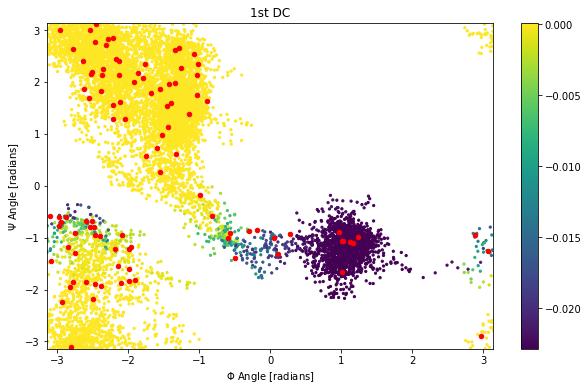

In [74]:
cv_phi=compute_dihedrals_phi(X_FT)
cv_psi=compute_dihedrals_psi(X_FT)

cv_phi_IC=compute_dihedrals_phi(initial_conditions)
cv_psi_IC=compute_dihedrals_psi(initial_conditions)


fig = plt.figure(figsize=(10,6))
x1=plt.scatter(cv_phi, cv_psi, c=evecs[:,0], s=5)
cbar=plt.colorbar(x1)

plt.scatter(cv_phi_IC, cv_psi_IC, c='r', s=20)

   
#plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-np.pi, np.pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-np.pi, np.pi)
plt.title('1st DC')

plt.savefig(savingfolder+'/init_cond_alanine.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

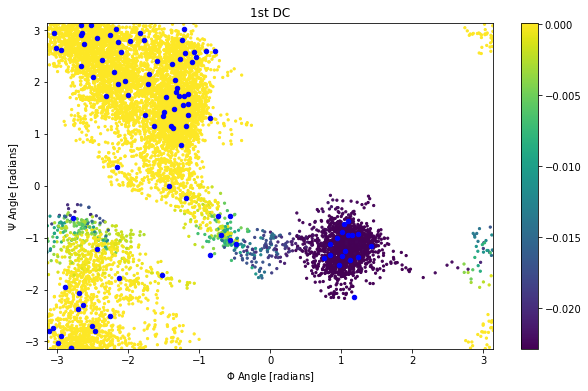

In [75]:
# check visually random choice of initial points

initial_conditions_random=X_FT[np.random.randint(len(X_FT),size = nrInitialPoints)]

cv_phi=compute_dihedrals_phi(X_FT)
cv_psi=compute_dihedrals_psi(X_FT)

cv_phi_IC_rand=compute_dihedrals_phi(initial_conditions_random)
cv_psi_IC_rand=compute_dihedrals_psi(initial_conditions_random)


fig = plt.figure(figsize=(10,6))
x1=plt.scatter(cv_phi, cv_psi, c=evecs[:,0], s=5)
cbar=plt.colorbar(x1)

#plt.scatter(cv_phi_IC, cv_psi_IC, c='r', s=20)
plt.scatter(cv_phi_IC_rand, cv_psi_IC_rand, c='b', s=20)

   
#plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-np.pi, np.pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-np.pi, np.pi)
plt.title('1st DC')

plt.savefig(savingfolder+'/random_init_cond_alanine.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

# Iterate Langevin to unbias

In [135]:
def Langevin_step(x , v, f,a, b,  dt):
    
    v = v + ((0.5*dt ) * f/ smpl.model.masses)
    x = x + ((0.5*dt ) * v)


    v = (a * v) + b * np.random.randn(*x.shape) * np.sqrt(smpl.kT / smpl.model.masses)

    x = x + ((0.5*dt ) * v)
    f=smpl.model.force(x)

    v = v + ((0.5*dt ) * f / smpl.model.masses)
    
    return x, v , f

In [136]:
# increase temperature

T_increased = 1000
temperature =  T_increased * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 1.0 * unit.femtosecond

temperatureAlpha= 0.0* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')


T = 300
temperature =  T * unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')




1913.6201899 K
698.135504523 K


In [137]:
savingfolder_results = 'LangevinUnbiasFigures/Alanine/nrpoints_'+repr(nrInitialPoints)+'/T_'+repr(smpl.integrator.temperature.value_in_unit(unit.kelvin))
newpath = os.path.join(os.getcwd(),savingfolder_results)
if not os.path.exists(newpath):
        os.makedirs(newpath)

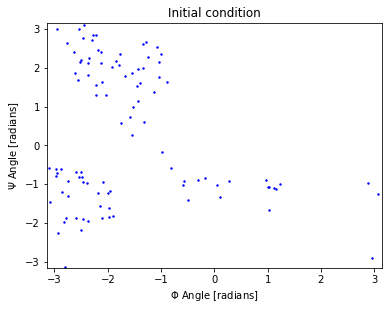

In [ ]:
numberOfLangevinSteps = 10000

X_short = np.copy(initial_conditions)
XL = []
[XL.append( X_short[n] * smpl.model.x_unit) for n in range(X_short.shape[0])]

kT = smpl.kT
mass = smpl.model.masses 

q = np.copy(X_short)

plotSamplingDihedrals_fromData(q, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Initial condition')

  

a = np.exp(-smpl.integrator.gamma * (smpl.integrator.dt))
b = np.sqrt(1 - np.exp(-2 * smpl.integrator.gamma * (smpl.integrator.dt)))

X_result = list()
    
for n in range(len(XL)):
        
    fLan = smpl.model.force(XL[n])
    v = np.random.randn(*XL[n].shape) * np.sqrt(smpl.kT / smpl.model.masses)
    for i in range(numberOfLangevinSteps):
            XL[n], v, fLan = Langevin_step(XL[n] , v, fLan,a, b,  smpl.integrator.dt)
            
            if numberOfLangevinSteps > 1000:
                if i > 1000:
                    X_result.append(np.asarray(XL[n]))
            else:
                X_result.append(np.asarray(XL[n]))
            #q[n,:,:] =  np.copy(XL[n].value_in_unit(smpl.model.x_unit))
            #X_result.append(q)

X_result = np.asarray(X_result)
    
## plot progress
plotSamplingDihedrals_fromData(X_result, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Iteration '+repr(n))
if np.isnan(q).any():
    print('Explosion at iteration '+repr(ns)+'. Nan.')
    

In [ ]:

plotSamplingDihedrals_fromData(X_short, smpl.model.testsystem.topology, methodName=None, color='b', title='Initial state')
plotSamplingDihedrals_fromData(X_result, smpl.model.testsystem.topology, methodName=None, color='b', title='After '+repr(X_result.shape[0])+' Langevin steps')


In [ ]:


np.save(savingfolder_results+'/results.npy',X_result)
np.save(savingfolder_results+'/numberOfSteps.npy',numberOfLangevinSteps)
np.save(savingfolder_results+'/intialPoints.npy',X_short)


In [ ]:
X_result_all = np.load(savingfolder_results+'/results.npy')
# X_result = X_result_all[1000:]
# print(X_result.shape)

In [ ]:
print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E_res = helpers.computeEnergy(X_result, smpl)

qTargetDistribution_higher_temperature= helpers.computeTargetMeasure(X_result, smpl, E_res)
qTargetDistribution_target= helpers.computeTargetMeasure(X_result, smpl_target, E_res)

weights =  qTargetDistribution_target / qTargetDistribution_higher_temperature

# fig = plt.figure(figsize=(16,6))
# ax = fig.add_subplot(121)
# cax = ax.hist(E, 1000, normed=True)
# ax.set_title('Histogram Energy')


# ax2 = fig.add_subplot(122)
# cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
# ax2.set_xlabel(cv_name)
# ax2.set_ylabel('Energy')
# ax2.set_title('Potential Energy')

#fig.savefig(simulationFolder+'/energy.png')

#plt.show()

# Compare free energies with reference

In [ ]:
# load reference free energy profile at 300 K
reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

FE_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE_phi.npy')
bc_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins_phi.npy')

FE_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE.npy')
bc_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins.npy')

In [ ]:
#weights_all = weights
print(len(weights_all))
print(len(weights_all))
#weights=weights_all
print(smpl.kT)
print(smpl_target.kT)

In [ ]:
import imp
imp.reload(helpers)

In [ ]:
nrBins=100
shift=10

#print('Computing collective variable of trajectory of  '+repr(len(X_short))+' points')
print('Computing collective variable of trajectory of  '+repr(len(X_result))+' points')
cv=compute_dihedrals_phi(X_FT)
cv_langevin=compute_dihedrals_phi(X_result[shift:])
weights_sh=weights_all[shift:]


free_energy_raw_phi, bin_centers_raw_phi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
free_energy_Langevin_phi, bin_centers_Langevin_phi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)

cv=compute_dihedrals_psi(X_FT)
cv_langevin=compute_dihedrals_psi(X_result[shift:])

free_energy_raw_psi, bin_centers_raw_psi, xe_raw, ye_raw = compute_free_energy(cv, nrbins = nrBins, err_bar=True)
free_energy_Langevin_psi, bin_centers_Langevin_psi = compute_free_energy(cv_langevin, nrbins = nrBins, weights=weights_sh)

fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(121)
ax.plot(bin_centers_raw_phi, free_energy_raw_phi, '-*b')#s=5, c='b', marker='o')
#ax.plot(bin_centers_raw_phi, free_energy_raw_phi+ye_raw, ':b')#s=5, c='b', marker='o')
#ax.plot(bin_centers_raw_phi, free_energy_raw_phi-ye_raw, ':b')#s=5, c='b', marker='o')

ax.plot(bin_centers_Langevin_phi, free_energy_Langevin_phi,'-*g')# s=5, c='g', marker='o')
ax.plot(bc_ref_phi, FE_ref_phi,'-*r')# s=5, c='r', marker='o')
plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
ax.set_xlabel('Dihedral angle phi')
ax.set_ylabel('Free energy [kT]')


ax = fig.add_subplot(122)
ax.plot(bin_centers_raw_psi, free_energy_raw_psi, '-*b')#s=5, c='b', marker='o')
ax.plot(bin_centers_Langevin_psi, free_energy_Langevin_psi,'-*g')# s=5, c='g', marker='o')
ax.plot(bc_ref_psi, FE_ref_psi,'-*r')# s=5, c='r', marker='o')
plt.legend(['Raw enhanced', 'Langevin', 'Reference'])
ax.set_xlabel('Dihedral angle psi')
ax.set_ylabel('Free energy [kT]')


# fig = plt.figure(figsize=(16,6))

# ax = fig.add_subplot(121)
# ax.scatter(bin_centers_raw_phi, free_energy_raw_phi, s=5, c='b', marker='o')
# ax.scatter(bin_centers_Langevin_phi, free_energy_Langevin_phi, s=5, c='g', marker='o')
# ax.scatter(bc_ref_phi, FE_ref_phi, s=5, c='r', marker='o')
# plt.legend(['raw enahnced', 'Langevin', 'reference'])
# ax.set_xlabel('Dihedral angle phi')
# ax.set_ylabel('Free energy [kT]')


# ax = fig.add_subplot(122)
# ax.scatter(bin_centers_raw_psi, free_energy_raw_psi, s=5, c='b', marker='o')
# ax.scatter(bin_centers_Langevin_psi, free_energy_Langevin_psi, s=5, c='g', marker='o')
# ax.scatter(bc_ref_psi, FE_ref_psi, s=5, c='r', marker='o')
# plt.legend(['raw enahnced', 'Langevin', 'reference'])
# ax.set_xlabel('Dihedral angle psi')
# ax.set_ylabel('Free energy [kT]')



plt.savefig(savingfolder_results+'/free_energy_steined_langevin.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()


In [ ]:
np.save(savingfolder_results+'/free_energy_raw_phi.npy',free_energy_raw_phi)
np.save(savingfolder_results+'/bin_centers_raw_phi.npy',bin_centers_raw_phi)

np.save(savingfolder_results+'/free_energy_raw_psi.npy',free_energy_raw_psi)
np.save(savingfolder_results+'/bin_centers_raw_psi.npy',bin_centers_raw_psi)

np.save(savingfolder_results+'/bin_centers_Langevin_phi.npy',bin_centers_Langevin_phi)
np.save(savingfolder_results+'/free_energy_Langevin_phi.npy',free_energy_Langevin_phi)

np.save(savingfolder_results+'/bc_ref_phi.npy',bc_ref_phi)
np.save(savingfolder_results+'/FE_ref_phi.npy',FE_ref_phi)

np.save(savingfolder_results+'/bin_centers_Langevin_psi.npy',bin_centers_Langevin_psi)
np.save(savingfolder_results+'/free_energy_Langevin_psi.npy',free_energy_Langevin_psi)


np.save(savingfolder_results+'/FE_ref_psi.npy',FE_ref_psi)
np.save(savingfolder_results+'/bc_ref_psi.npy',bc_ref_psi)

